# Imports

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Literal, List, Dict
import time
import pandas as pd
import seaborn as sns

 # Option Pricing Class

In [2]:
@dataclass
class OptionParams:
    S: float  # Spot price
    K: float  # Strike price
    T: float  # Time to maturity
    r: float  # Risk-free rate
    sigma: float  # Volatility
    option_type: Literal['call', 'put']



class OptionPricingModel:
    def __init__(self, params: OptionParams):
        self.params = params


    def black_scholes(self) -> float:
        S, K, T, r, sigma = self.params.S, self.params.K, self.params.T, self.params.r, self.params.sigma
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if self.params.option_type == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    
    def monte_carlo_american(self, steps: int = 100, simulations: int = 10000): # Change number of simulations to whatever you want
        S, K, T, r, sigma = self.params.S, self.params.K, self.params.T, self.params.r, self.params.sigma
        dt = T / steps
        discount_factor = np.exp(-r * dt)
        
        # Vectorized path generation
        random_walks = np.random.standard_normal((simulations, steps))
        paths = S * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * random_walks, axis=1))
        paths = np.insert(paths, 0, S, axis=1)

        # Calculate payoffs at each time step
        if self.params.option_type == 'put':
            payoffs = np.maximum(K - paths, 0)
        else:
            payoffs = np.maximum(paths - K, 0)

        # Initialize option values with payoffs at maturity
        option_values = payoffs[:, -1]

        # Longstaff-Schwartz Algorithm
        for j in range(steps - 1, 0, -1):
            # Step 1: Identify in-the-money paths
            itm_paths = payoffs[:, j] > 0
            
            if np.sum(itm_paths) > 0:
                # Step 2: Regression
                X = paths[itm_paths, j]
                Y = option_values[itm_paths] * discount_factor
                regression = np.polyfit(X, Y, 2)
                
                # Step 3: Calculate continuation values
                continuation_values = np.polyval(regression, X)
                
                # Step 4: Compare immediate exercise with continuation value
                immediate_exercise = payoffs[itm_paths, j]
                exercise = immediate_exercise > continuation_values
                
                # Step 5: Update option values
                option_values[itm_paths] = np.where(exercise, 
                                                    immediate_exercise, 
                                                    option_values[itm_paths] * discount_factor)
            else:
                # If no in-the-money paths, just discount the option values
                option_values *= discount_factor

        return np.mean(option_values), paths


    def binomial_tree_american(self, steps: int = 100):
        S, K, T, r, sigma = self.params.S, self.params.K, self.params.T, self.params.r, self.params.sigma
        dt = T / steps
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
        discount = np.exp(-r * dt)

        stock_prices = S * d**(np.arange(steps, -1, -1)) * u**(np.arange(steps+1))
        option_values = np.maximum(K - stock_prices, 0) if self.params.option_type == 'put' else np.maximum(stock_prices - K, 0)

        for i in range(steps-1, -1, -1):
            continuation_values = discount * (p * option_values[1:i+2] + (1-p) * option_values[:i+1])
            exercise_values = np.maximum(K - stock_prices[:i+1], 0) if self.params.option_type == 'put' else np.maximum(stock_prices[:i+1] - K, 0)
            option_values[:i+1] = np.maximum(continuation_values, exercise_values)

        return option_values[0]



def plot_monte_carlo_paths(paths: np.ndarray, params: OptionParams, case_index: int):
    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, :].T, color='blue', alpha=0.1)
    plt.title(f'Monte Carlo Simulation Paths - Case {case_index + 1}\n'
              f'({params.option_type.capitalize()} Option, S={params.S}, K={params.K}, T={params.T}, r={params.r}, σ={params.sigma})')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.axhline(y=params.K, color='r', linestyle='--', label='Strike Price')
    plt.legend()
    plt.tight_layout()
    plt.show()



def run_test_suite(test_cases: List[Dict[str, float]], models: List[str] = ['Black-Scholes', 'Monte Carlo', 'Binomial Tree']):
    results = []
    for case_index, case in enumerate(test_cases):
        params = OptionParams(**case)
        model = OptionPricingModel(params)
        
        for method in models:
            start_time = time.time()
            if method == 'Black-Scholes':
                price = model.black_scholes()
                paths = None
            elif method == 'Monte Carlo':
                price, paths = model.monte_carlo_american()
                plot_monte_carlo_paths(paths, params, case_index)
            elif method == 'Binomial Tree':
                price = model.binomial_tree_american()
                paths = None
            else:
                raise ValueError(f"Unknown method: {method}")
            computation_time = time.time() - start_time
            
            results.append({
                'Method': method,
                'Option Type': params.option_type,
                'S': params.S,
                'K': params.K,
                'T': params.T,
                'r': params.r,
                'sigma': params.sigma,
                'Price': price,
                'Computation Time': computation_time
            })
    
    return pd.DataFrame(results)



def analyze_results(results: pd.DataFrame):
    print("\n===== Option Pricing Model Comparison =====")
    
    # Summary statistics
    summary = results.groupby(['Method', 'Option Type']).agg({
        'Price': ['mean', 'std'],
        'Computation Time': ['mean', 'std']
    }).round(4)
    print("\nSummary Statistics:")
    print(summary)
    
    # Price comparison plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Method', y='Price', hue='Option Type', data=results)
    plt.title('Option Price Comparison Across Models')
    plt.show()
    
    # Computation time comparison plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Method', y='Computation Time', data=results)
    plt.title('Computation Time Comparison Across Models')
    plt.yscale('log')
    plt.show()
    
    # Correlation analysis
    correlation = results.groupby('Method').apply(lambda x: x['Price'].corr(x['Computation Time'])).round(4)
    print("\nCorrelation between Price and Computation Time:")
    print(correlation)

# Output

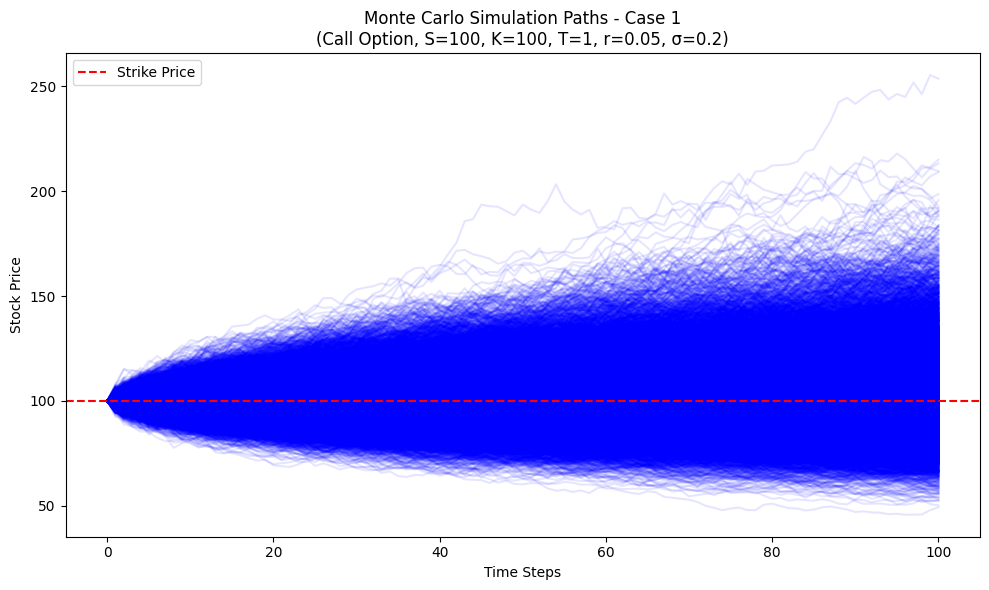

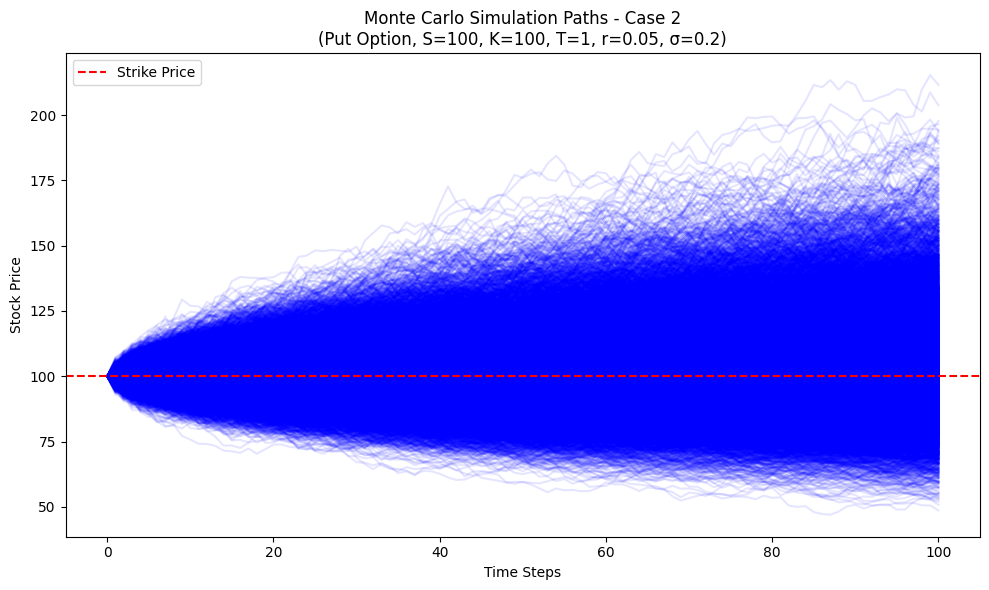

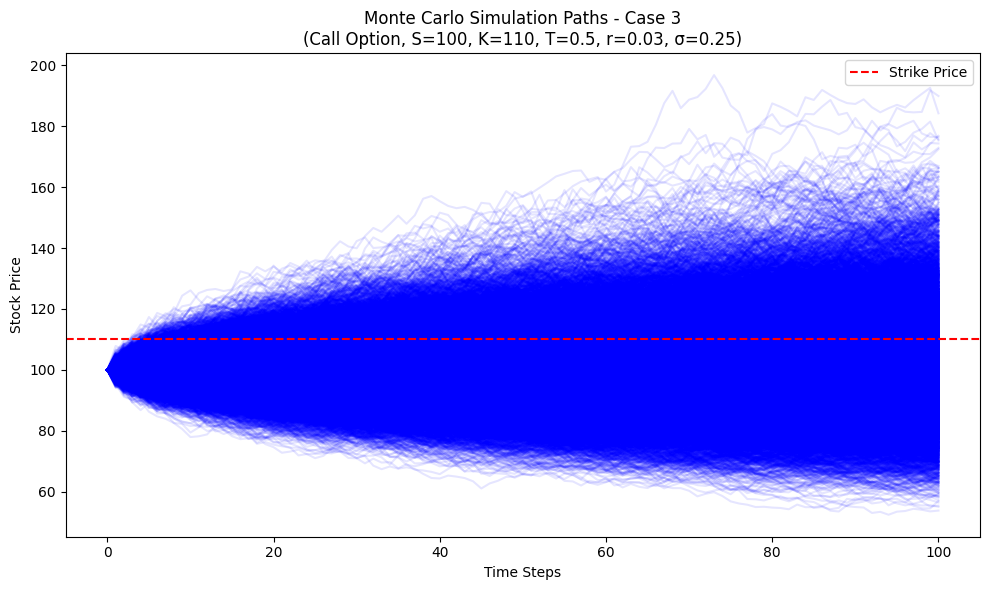

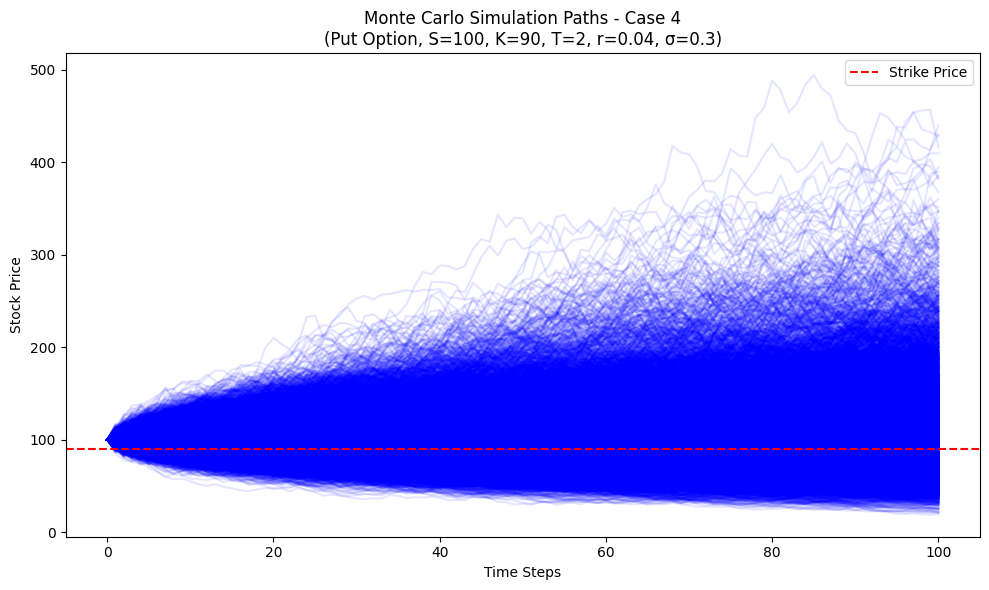

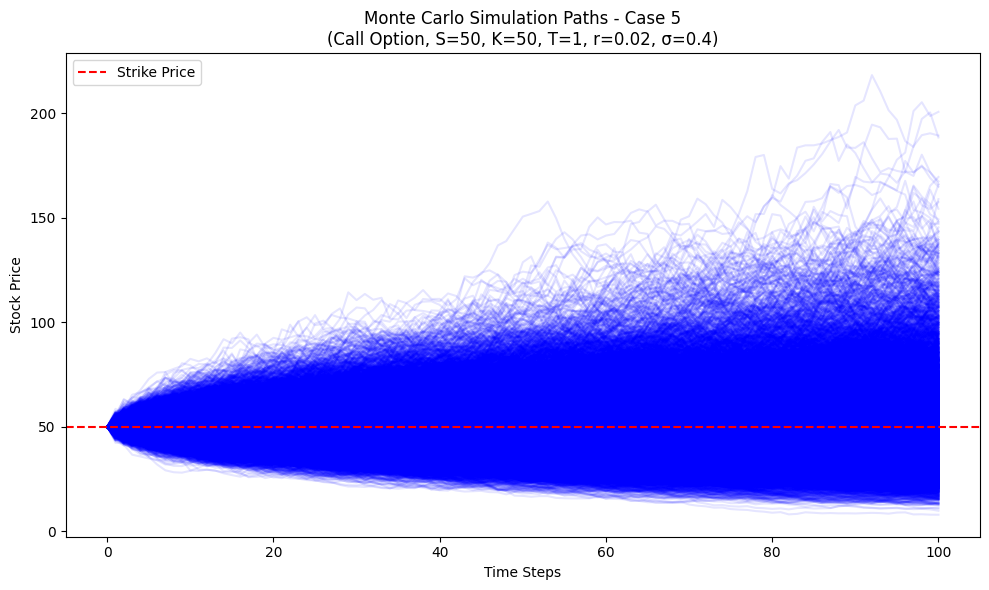

C:\Users\saumy\AppData\Local\Temp\ipykernel_9120\282523521.py:122: RankWarning: Polyfit may be poorly conditioned
  price, paths = model.monte_carlo_american()


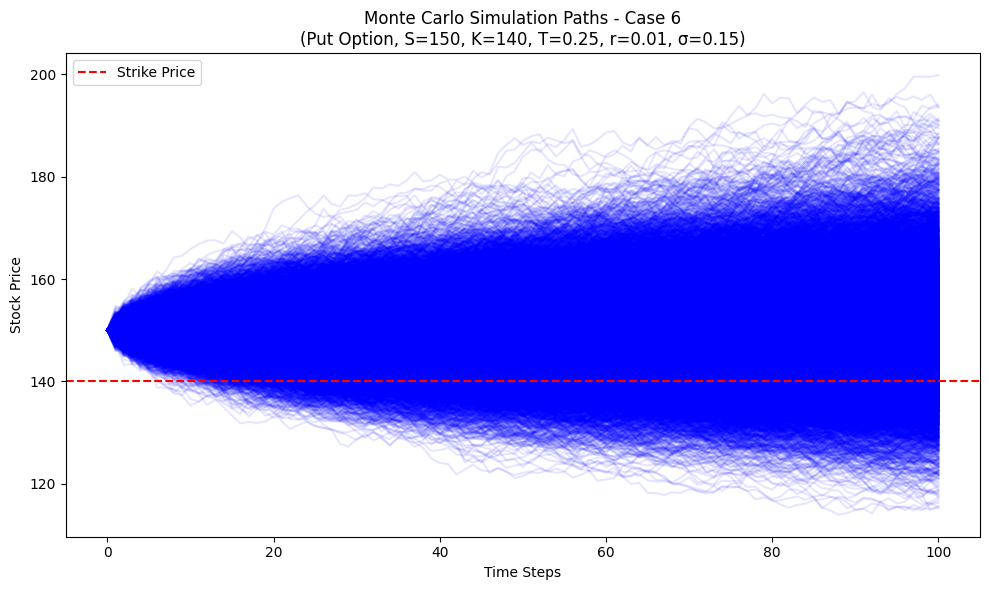


===== Option Pricing Model Comparison =====

Summary Statistics:
                             Price          Computation Time        
                              mean      std             mean     std
Method        Option Type                                           
Binomial Tree call          7.5571   3.3297           0.0017  0.0006
              put          81.3915  10.6575           0.0017  0.0006
Black-Scholes call          7.5671   3.3458           0.0003  0.0006
              put           4.9659   3.7122           0.0000  0.0000
Monte Carlo   call          7.6242   3.3002          11.1180  1.3531
              put           5.4468   4.1441          11.0043  1.3296


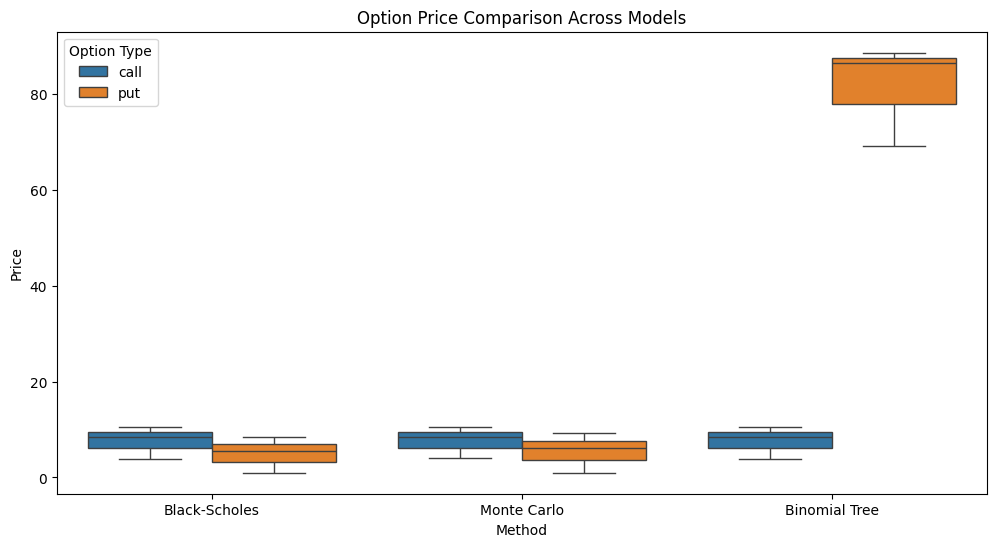

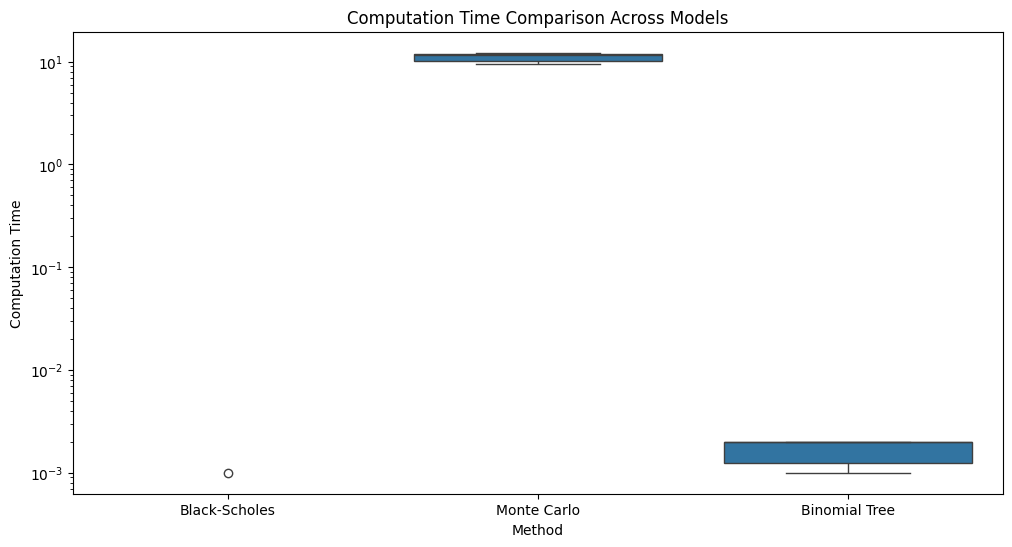


Correlation between Price and Computation Time:
Method
Binomial Tree   -0.0344
Black-Scholes    0.2947
Monte Carlo      0.0862
dtype: float64

Extreme Values:
                  Price            Computation Time           
                    min        max              min        max
Method                                                        
Binomial Tree  3.908068  88.563040         0.001000   0.002001
Black-Scholes  0.987401  10.450584         0.000000   0.000999
Monte Carlo    1.032751  10.462083         9.493001  12.243998

Detailed results saved to 'option_pricing_results.csv'


In [3]:
if __name__ == "__main__":
    # Define a comprehensive set of test cases
    test_cases = [
        {'S': 100, 'K': 100, 'T': 1, 'r': 0.05, 'sigma': 0.2, 'option_type': 'call'},
        {'S': 100, 'K': 100, 'T': 1, 'r': 0.05, 'sigma': 0.2, 'option_type': 'put'},
        {'S': 100, 'K': 110, 'T': 0.5, 'r': 0.03, 'sigma': 0.25, 'option_type': 'call'},
        {'S': 100, 'K': 90, 'T': 2, 'r': 0.04, 'sigma': 0.3, 'option_type': 'put'},
        {'S': 50, 'K': 50, 'T': 1, 'r': 0.02, 'sigma': 0.4, 'option_type': 'call'},
        {'S': 150, 'K': 140, 'T': 0.25, 'r': 0.01, 'sigma': 0.15, 'option_type': 'put'},
    ]

    # Run the test suite
    results = run_test_suite(test_cases)

    analyze_results(results)

    # Check for extreme values
    print("\nExtreme Values:")
    print(results.groupby('Method').agg({'Price': ['min', 'max'], 'Computation Time': ['min', 'max']}))

    # Save results to CSV
    results.to_csv('option_pricing_results.csv', index=False)
    print("\nDetailed results saved to 'option_pricing_results.csv'")